In [1]:
%reset
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from functions import loader, splt, fitter, stats, grouper
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat

savedir = "G01/"

In [3]:
all_data = loader.load_data( "../Plans20221024TheHugescan_20221024/**/" )
data = loader.remove_duplicates( all_data,
    lambda d: ( d['dep_polymers'], d['side'], d['defects_frac'], d['gamma'] ),
    lambda d: d['runned_replicas']
)
len( data )

154

In [4]:
for d in data:
    # x, y = fitter.rebin_n( d['h_x'], d['h'], 50 )
    # d['fits'] = fitter.entropyc_fits( x, y, d, threshold=0.5, plot=False )
    d['jamming_frac_avg'] = np.mean( d['chunks'] ) / d['side'] / d['side']
    d['jamming_frac_std'] = np.std( d['chunks'], ddof = 1 ) / d['side'] / d['side']
    
    # d['np_std'] = np.std( d['chunks'], ddof=1 ) / d['side'] / d['side']

    d['np_std_witherr'] = stats.compute_in_decades(
        d['chunks'],
        lambda arr: np.std( arr, ddof = 1 ) / d['side'] / d['side']
    )

In [5]:
filtered_data = data

In [6]:
loader.export( filtered_data, savedir + "data.json", columns = ['side','defects_frac','gamma','dep_polymers','runned_replicas','jamming_frac_avg','jamming_frac_std'], renames = {} )

FileNotFoundError: [Errno 2] No such file or directory: 'G01/data.json'

In [7]:
from functions import CEfitter

# to_use = lambda d: d['fits']['Gauss']['pars'][2]
# to_use = lambda d: d['np_std']
to_use = lambda d: d['np_std_witherr']

grouped_data = grouper.extract_xy( filtered_data, ['dep_polymers', 'defects_frac', 'gamma'], lambda d: d['side'], to_use )

grouped_data = grouped_data[ np.vectorize( lambda g : len( g['x'] ) > 2 )( grouped_data ) ]

# splt.init( len( grouped_data ) / 4 + 1, 4 )
for i_g, g in enumerate( grouped_data ):
    # splt.next()
    # print( i_g, end=': ')
    g['B'], logx, logyB = CEfitter.estimate_B_errony( g['x'] , g['y'] )
    # plt.title( i_g )
    # g['oneovernu'], g['somethingrelatedtoA'] = CEfitter.estimate_oneovernu( logx, logyB )
    g['oneovernu_b'], g['somethingrelatedtoA_b'] = CEfitter.estimate_oneovernu_bis( logx, logyB, 0.013 )

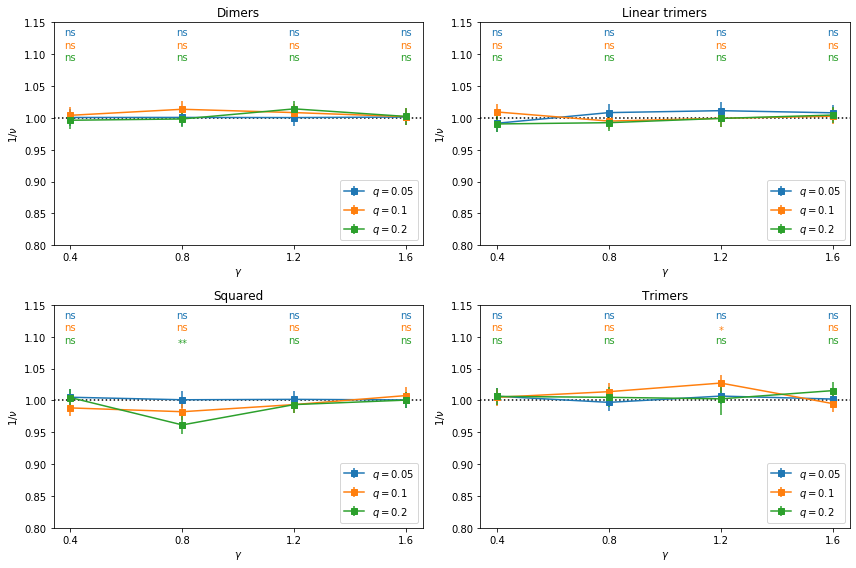

In [8]:
splt.oneitem_iterate_errorbar(
    len( grouped_data ),
    lambda d: grouped_data[d]['dep_polymers'],
    lambda d: grouped_data[d]['defects_frac'],
    lambda d: grouped_data[d]['gamma'],
    lambda d: [
        grouped_data[d]['oneovernu_b']
    ],
    lambda it, l: [
        { 'label': fr"$q = {l}$", 'ls': '-', 'marker': 's' },
    ],
    lambda it: (
        plt.title( fr"{it}" ),
        plt.xlabel( fr"$\gamma$" ),
        plt.ylabel( fr"$1/\nu$" ),
        plt.ylim( 0.8, 1.15 ),
        splt.hline( 1 )
    ),
    pvals_ys = [ 1.13, 1.11, 1.09 ],
    pvals_exp = 1
)

plt.tight_layout()
plt.savefig( savedir + '/oneovernu.pdf' )
plt.savefig( savedir + '/oneovernu.png' )

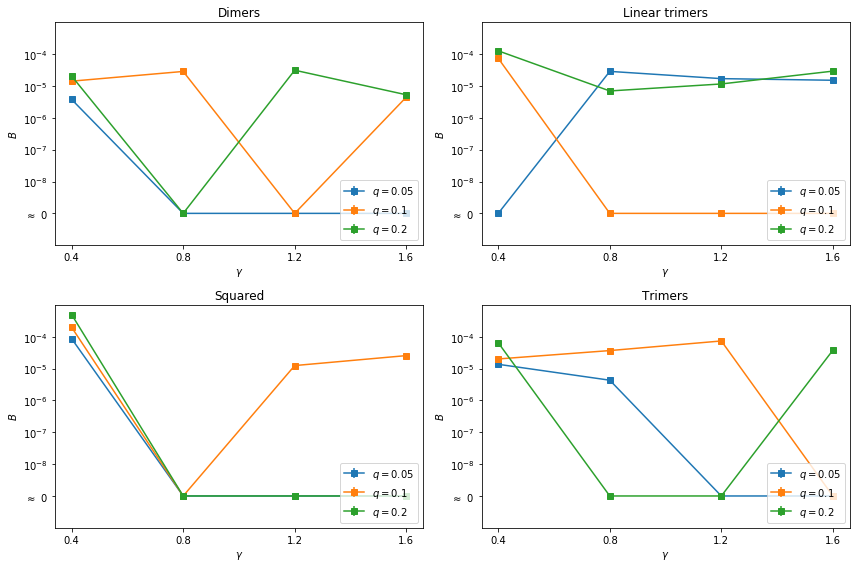

In [9]:
splt.oneitem_iterate_errorbar(
    len( grouped_data ),
    lambda d: grouped_data[d]['dep_polymers'],
    lambda d: grouped_data[d]['defects_frac'],
    lambda d: grouped_data[d]['gamma'],
    lambda d: [
        np.max( [ grouped_data[d]['B'], ufloat( 1e-9, 1e-10 ) ] )
    ],
    lambda it, l: [
        { 'label': fr"$q = {l}$", 'ls': '-', 'marker': 's' },
    ],
    lambda it: (
        plt.title( fr"{it}" ),
        plt.xlabel( fr"$\gamma$" ),
        plt.ylabel( fr"$B$" ),
        plt.yscale( 'log' ),
        plt.ylim( 1e-10, 1e-3 ),
        plt.yticks(
            [ 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9 ],
            [ r"$10^{-4}$", r"$10^{-5}$", r"$10^{-6}$", r"$10^{-7}$", r"$10^{-8}$", r"$\approx$ 0" ] ),
            plt.minorticks_off()
        # splt.hline( 0 )
    )
)

plt.tight_layout()
plt.savefig( savedir + '/B.pdf' )
plt.savefig( savedir + '/B.png' )